In [10]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
from pprint import pprint

import re

In [3]:
# display list of images with image channel handling
def display_image(*imgs):
    n = len(imgs)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        if len(imgs[i].shape) == 2:  # grayscale
            plt.imshow(imgs[i], cmap='gray')
        else:  # color
            plt.imshow(cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

In [4]:
class StereoVision:
    def __init__(self, calib):
        """Initialize stereo vision with calibration parameters."""
        self.calib = calib
        self.K0 = calib['cam0']
        self.K1 = calib['cam1']
        self.baseline = calib['baseline']
        self.doffs = calib['doffs']
        
        # Stereo matcher
        self.stereo = cv.StereoSGBM_create(
            minDisparity=calib['vmin'],
            numDisparities=calib['ndisp'] - calib['vmin'],
            blockSize=5,
            P1=8 * 3 * 5**2,
            P2=32 * 3 * 5**2,
            disp12MaxDiff=1,
            uniquenessRatio=10,
            speckleWindowSize=100,
            speckleRange=32
        )
        
        # Q matrix for reprojection
        self.Q = self._compute_Q_matrix()
    
    def _compute_Q_matrix(self):
        """Compute reprojection matrix for 3D reconstruction."""
        cx0, cy0 = self.K0[0, 2], self.K0[1, 2]
        fx = self.K0[0, 0]
        
        Q = np.array([
            [1, 0, 0, -cx0],
            [0, 1, 0, -cy0],
            [0, 0, 0, fx],
            [0, 0, 1/self.baseline, 0]
        ])
        return Q
    
    def compute_disparity(self, img_left, img_right):
        """
        Compute disparity map from stereo image pair.
        
        Parameters:
        -----------
        img_left : ndarray
            Left camera image (grayscale or color)
        img_right : ndarray
            Right camera image (grayscale or color)
            
        Returns:
        --------
        disparity : ndarray
            Disparity map (float32)
        """
        # Convert to grayscale if needed
        if len(img_left.shape) == 3:
            img_left = cv.cvtColor(img_left, cv.COLOR_BGR2GRAY)
        if len(img_right.shape) == 3:
            img_right = cv.cvtColor(img_right, cv.COLOR_BGR2GRAY)
        
        # Compute disparity
        disparity = self.stereo.compute(img_left, img_right).astype(np.float32) / 16.0
        
        # Apply valid disparity mask
        disparity[disparity < self.calib['vmin']] = 0
        disparity[disparity > self.calib['vmax']] = 0
        
        return disparity
    
    def disparity_to_depth(self, disparity):
        """
        Convert disparity map to depth map.
        
        Parameters:
        -----------
        disparity : ndarray
            Disparity map
            
        Returns:
        --------
        depth : ndarray
            Depth map in mm
        """
        # Avoid division by zero
        depth = np.zeros_like(disparity)
        valid = disparity > 0
        
        # Z = (f * baseline) / disparity
        fx = self.K0[0, 0]
        depth[valid] = (fx * self.baseline) / (disparity[valid] + self.doffs)
        
        return depth
    
    def reconstruct_3d(self, disparity, img_left=None):
        """
        Reconstruct 3D point cloud from disparity map.
        
        Parameters:
        -----------
        disparity : ndarray
            Disparity map
        img_left : ndarray, optional
            Left image for color information
            
        Returns:
        --------
        points : ndarray
            3D points (N x 3) in camera coordinates
        colors : ndarray, optional
            RGB colors (N x 3) if img_left provided
        """
        # Create 3D points using Q matrix
        points_3d = cv.reprojectImageTo3D(disparity, self.Q)
        
        # Filter valid points
        mask = (disparity > self.calib['vmin']) & (disparity < self.calib['vmax'])
        points = points_3d[mask]
        
        if img_left is not None:
            if len(img_left.shape) == 2:
                colors = np.stack([img_left[mask]]*3, axis=1)
            else:
                colors = img_left[mask]
            return points, colors
        
        return points
    
    def rectify_images(self, img_left, img_right):
        """
        Rectify stereo image pair (if rotation/translation known).
        Note: Requires R, T parameters which aren't in this calibration.
        """
        # This would require rotation and translation between cameras
        # For now, assume images are already rectified
        return img_left, img_right
    
def load_calibration(filepath):
    with open(filepath, 'r') as f:
        content = f.read()
    
    calib = {}
    
    # Parse camera matrices
    for cam in ['cam0', 'cam1']:
        match = re.search(rf'{cam}=\[(.*?)\]', content, re.DOTALL)
        calib[cam] = np.array([[float(x) for x in row.split() if x] 
                               for row in match.group(1).split(';')])
    
    # Parse scalars
    for param in ['doffs', 'baseline', 'width', 'height', 'ndisp', 
                  'isint', 'vmin', 'vmax', 'dyavg', 'dymax']:
        val = float(re.search(rf'{param}=([\d.+-]+)', content).group(1))
        calib[param] = int(val) if param in ['width', 'height', 'ndisp', 'isint', 'vmin', 'vmax'] else val
    
    return calib

def load_pfm(filepath):
    """Load a PFM (Portable Float Map) file."""
    with open(filepath, 'rb') as f:
        header = f.readline().decode('utf-8').rstrip()
        channels = 3 if header == 'PF' else 1
        
        dim_line = f.readline().decode('utf-8').rstrip()
        width, height = map(int, dim_line.split())
        
        scale = float(f.readline().decode('utf-8').rstrip())
        endian = '<' if scale < 0 else '>'
        
        data = np.fromfile(f, endian + 'f')
    
    shape = (height, width, 3) if channels == 3 else (height, width)
    data = np.reshape(data, shape)
    return np.flipud(data), abs(scale)

{'baseline': 342.789,
 'cam0': array([[4.029299e+03, 0.000000e+00, 1.213198e+03],
       [0.000000e+00, 4.029299e+03, 9.759640e+02],
       [0.000000e+00, 0.000000e+00, 1.000000e+00]]),
 'cam1': array([[4.029299e+03, 0.000000e+00, 1.484019e+03],
       [0.000000e+00, 4.029299e+03, 9.759640e+02],
       [0.000000e+00, 0.000000e+00, 1.000000e+00]]),
 'doffs': 270.821,
 'dyavg': 0.0,
 'dymax': 0.0,
 'height': 1908,
 'isint': 0,
 'ndisp': 330,
 'vmax': 300,
 'vmin': 29,
 'width': 2800}


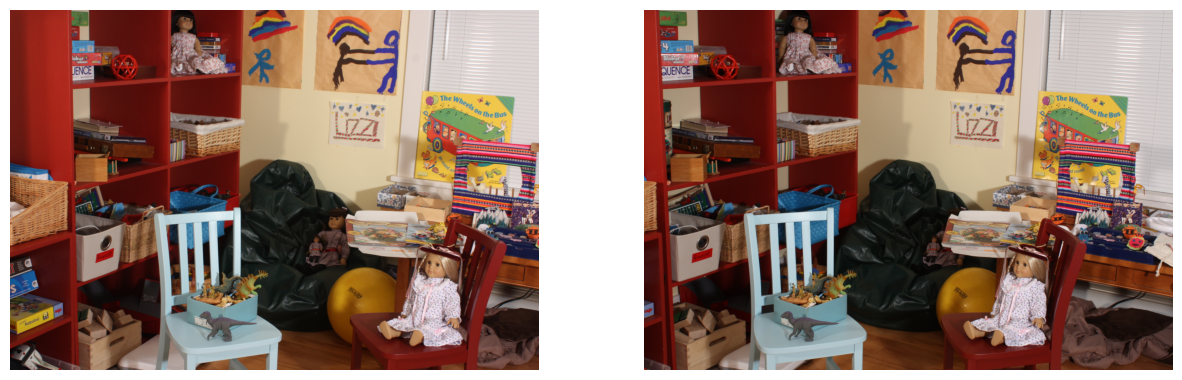

In [5]:
###
folder_path = "data/Playroom-perfect"

###
img_left = cv.imread(f"{folder_path}/im0.png")
img_right = cv.imread(f"{folder_path}/im1.png")
calib = load_calibration(f"{folder_path}/calib.txt")

pprint(calib)
display_image(img_left, img_right)


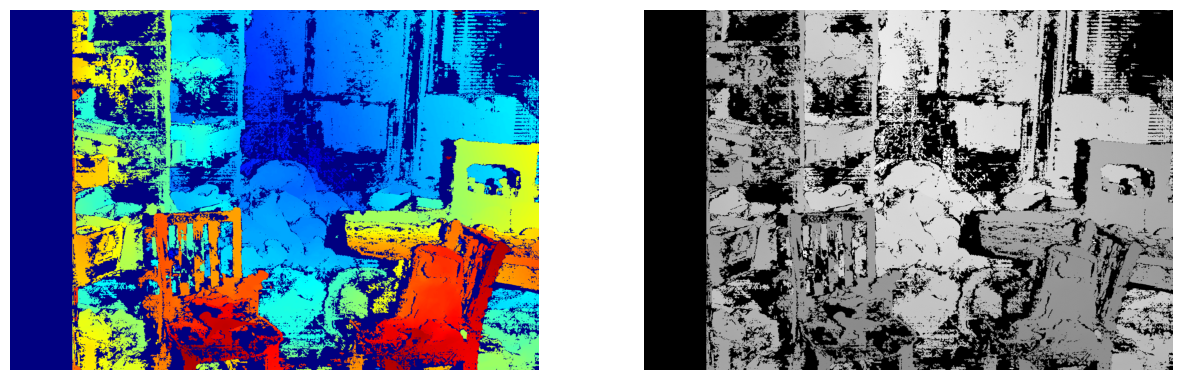

Point cloud size: (3133341, 3)
Depth range: 2419.7 - 4606.7 mm


In [7]:
# Initialize stereo vision
stereo = StereoVision(calib)

# Compute disparity
disparity = stereo.compute_disparity(img_left, img_right)

# Convert to depth
depth = stereo.disparity_to_depth(disparity)

# Reconstruct 3D point cloud
points, colors = stereo.reconstruct_3d(disparity, img_left)

# Visualize disparity
disparity_vis = cv.normalize(disparity, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
disparity_colormap = cv.applyColorMap(disparity_vis, cv.COLORMAP_JET)

display_image(disparity_colormap, depth / depth.max())

print(f"Point cloud size: {points.shape}")
print(f"Depth range: {depth[depth > 0].min():.1f} - {depth[depth > 0].max():.1f} mm")

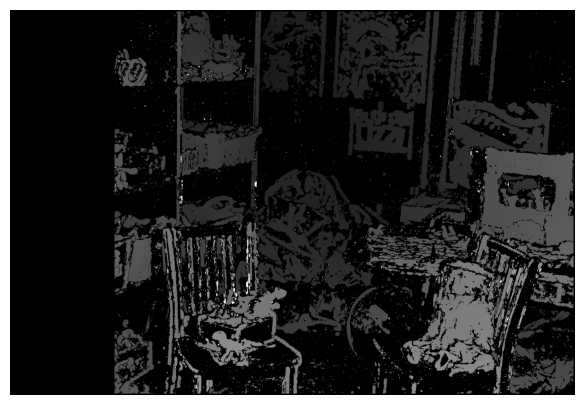

In [8]:
display_image(
    cv.StereoBM_create(numDisparities=512, blockSize=15).compute(
        cv.cvtColor(img_left, cv.COLOR_BGR2GRAY),
        cv.cvtColor(img_right, cv.COLOR_BGR2GRAY)
    )
)

Disparity scale: 0.003922


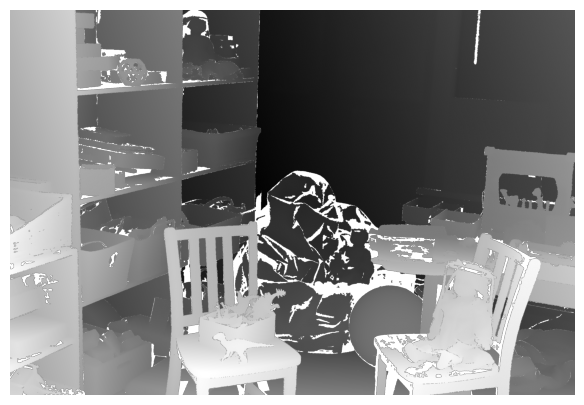

In [9]:
disparity, scale = load_pfm(f"{folder_path}/disp0.pfm")
print(f"Disparity scale: {scale}")
display_image(disparity)